In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve
import pickle
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import healpy as hp
from functools import partial

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm
#################################################functions and constants#################################################
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)
@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)
def z_dc(dc,h,om=Om0GLOB):
    func = lambda z :r_z(z, h, Om0GLOB) - dc
    zres = fsolve(func, 0.02)[0] 
    return zres
@njit
def phi2RA(phi):
    ret=np.rad2deg(phi)
    return ret
@njit
def theta2DEC(theta):
    ret=np.rad2deg(0.5*np.pi-theta)
    return ret
@njit
def RA2phi(RA):
    ret=np.deg2rad(RA)
    return ret
@njit
def DEC2theta(DEC):
    ret=0.5 * np.pi - np.deg2rad(DEC)
    return ret

In [ ]:
##########################################################################################################################

#read the flagship
save_cat_path=os.getcwd()
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)
#save_cat_path='/storage/DATA-03/astrorm3/Users/rcianca/DarkSirensStat/MyDSStat/'

flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
flag.columns=colnames

z_flag_min=flag['z'].min()
z_flag_max=flag['z'].max()
Nobj=flag.shape[0]
dl_flag_min=flag['dl'].min()
dl_flag_max=flag['dl'].max()
RA_flag_min=flag['right_ascension_degrees'].min()
RA_flag_max=flag['right_ascension_degrees'].max()
DEC_flag_min=flag['declination_degrees'].min()
DEC_flag_max=flag['declination_degrees'].max()
phi_flag_min=RA2phi(RA_flag_min)
phi_flag_max=RA2phi(RA_flag_max)
theta_flag_min=DEC2theta(DEC_flag_max)
theta_flag_max=DEC2theta(DEC_flag_min)

#denser bin
nbins=30
z_flag=np.asarray(flag['z'])
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
(n, bins, patches)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max))
delta_phi=phi_flag_max-phi_flag_min
theta_part=np.cos(theta_flag_min)-np.cos(theta_flag_max)
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
density=np.zeros(len(n))
for i,j in enumerate (bins[:-1]):
    z_part=integrate.quad(integrand,bins[i],bins[i+1])[0]
    Volume=delta_phi*theta_part*z_part#integrand
    density[i]=n[i]/Volume
desity_max=np.max(density)
##########################################################################################
z_max_unif=2.3
z_min_unif=0.3
z_part=integrate.quad(integrand,z_min_unif,z_max_unif)[0]
tot_volume=delta_phi*theta_part*z_part
uniform_numb=10#int(3*desity_max*tot_volume)+1
dcom_min=cosmoflag.comoving_distance(z_min_unif).value
dcom_max=cosmoflag.comoving_distance(z_max_unif).value

cat_name='Uniform_paper.txt'


#------------------points generator------------------
u = np.random.uniform(0,1,size=uniform_numb) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_flag_min,phi_flag_max,uniform_numb)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_flag_max),np.cos(theta_flag_min),uniform_numb) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
new_theta_gals=np.random.choice(theta_gals,len(dc_gals))

def uniform_volume(iteration):
    i = iteration
    numevent = i
    phigal = new_phi_gals[i]
    thetagal = new_theta_gals[i]
    dc = dc_gals[i]
    zz = z_dc(dc, href, Om0GLOB)
    dl = Dl_z(zz, href, Om0GLOB)
    proxy_row = {
        'Ngal': numevent,
        'Comoving Distance': dc,
        'Luminosity Distance': dl,
        'z': zz,
        'phi': phigal,
        'theta': thetagal
    }
    return proxy_row

colnames = ['Ngal', 'Comoving Distance', 'Luminosity Distance', 'z', 'phi', 'theta']
uniform_scaled = pd.DataFrame(columns=colnames)

arr = np.arange(0, len(dc_gals), dtype=int)
num_processors = 13

with Pool(num_processors) as p:
    tmp = p.map(uniform_volume, arr)

uniform_scaled = pd.DataFrame.from_records(tmp)

In [ ]:
os.chdir(save_cat_path)
uniform_scaled.to_csv(cat_name, header=None, index=False)
#uniform_scaled.to_pickle("Uniform_paper.pkl")
uniform_scaled.head()

In [ ]:
Parent_Catalogue = pd.read_csv('Uniform_paper.txt', header = None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Parent_Catalogue.columns=colnames
Parent_Cataloguepkl=pd.read_pickle("Uniform_paper.pkl")
print(Parent_Catalogue.shape,Parent_Catalogue.columns)

In [ ]:
Parent_Catalogue.head()

In [ ]:
Parent_Cataloguepkl.head()

# Test Ditributions

In [2]:
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f, xmin, xmax, N=1000000):
    uniform_samples = np.random.random(int(N))
    required_samples = sample(f, xmin, xmax)(uniform_samples)
    return required_samples

#-----------rejection-stuff------------
def float64_sample(g, xmin, xmax):
    x = np.linspace(xmin, xmax, 1000000, dtype=np.float64)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y, dtype=np.float64)            # cumulative distribution function, cdf
    cdf_y = cdf_y / cdf_y.max()     # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y, x, fill_value="extrapolate")  # this is a function
    return inverse_cdf

def float64_return_samples(f, xmin, xmax, N=1000000):
    uniform_samples = np.random.random(int(N)).astype(np.float64)
    required_samples = sample(f, xmin, xmax)(uniform_samples)
    return required_samples

In [9]:
def myS(x, m_min, dm):
    if x < m_min:
        return 0
    if m_min<=x<m_min+dm:
        tmp= (np.exp(dm/(x-m_min)+dm/(x-m_min-dm))+1)**(-1)
        return tmp
    else:
        return 1
    
def nomask_S(x, m_min, dm):
    x = np.asarray(x)
    s = np.ones_like(x)
    s[x < m_min] = 0
    mask = (m_min <= x) & (x < m_min + dm)
    s[mask] =(np.exp(dm / (x[mask] - m_min) + dm / (x[mask] - m_min - dm))+1)**(-1)
    return s

def S(x, m_min, dm):
    x = np.asarray(x)
    s = np.ones_like(x)
    s[x < m_min] = 0
    mask = (m_min <= x) & (x < m_min + dm)
    
    exp_values = dm / (x[mask] - m_min) + dm / (x[mask] - m_min - dm)
    
    # Avoid overflow by capping exp_values
    large_mask = exp_values > 700  # Value beyond which exp() will overflow
    safe_exp_values = np.where(large_mask, 700, exp_values)
    
    s[mask] = (np.exp(safe_exp_values) + 1) ** (-1)
    return s
    
def float64_S(x, m_min, dm):
    x = np.asarray(x, dtype=np.float64)
    s = np.ones_like(x, dtype=np.float64)
    s[x < m_min] = np.float64(0)
    mask = (m_min <= x) & (x < m_min + dm)
    
    exp_values = dm / (x[mask] - m_min) + dm / (x[mask] - m_min - dm)
    
    # Avoid overflow by capping exp_values
    large_mask = exp_values > 700  # Value beyond which exp() will overflow
    safe_exp_values = np.where(large_mask, 700, exp_values)
    
    s[mask] = (np.exp(safe_exp_values) + np.float64(1)) ** (-1)
    
    return s

def p_q(q, m1, m_min=m_min, dm=dm, b=b):
    return S(m1*q, m_min, dm) * q**b

In [10]:
# Set m1 for the test
m1 = 10#np.float64(10)
m_min = 4.59#np.float64(4.59)
dm = 4.82#np.float64(4.82)
b = 1.26#np.float64(1.26)
# Define the function with parameters
p_q_with_params = partial(p_q, m1=m1, m_min=m_min, dm=dm, b=b)

# Number of samples
num_samples = 1_00_000

# Sample the probability distribution
q_samples = return_samples(p_q_with_params, 0, 1, num_samples)

# Generate theoretical distribution for plotting
q_values = np.linspace(0, 1, 10000)
p_q_values = p_q_with_params(q_values)
p_q_values=p_q_values/np.trapz(p_q_values,q_values)

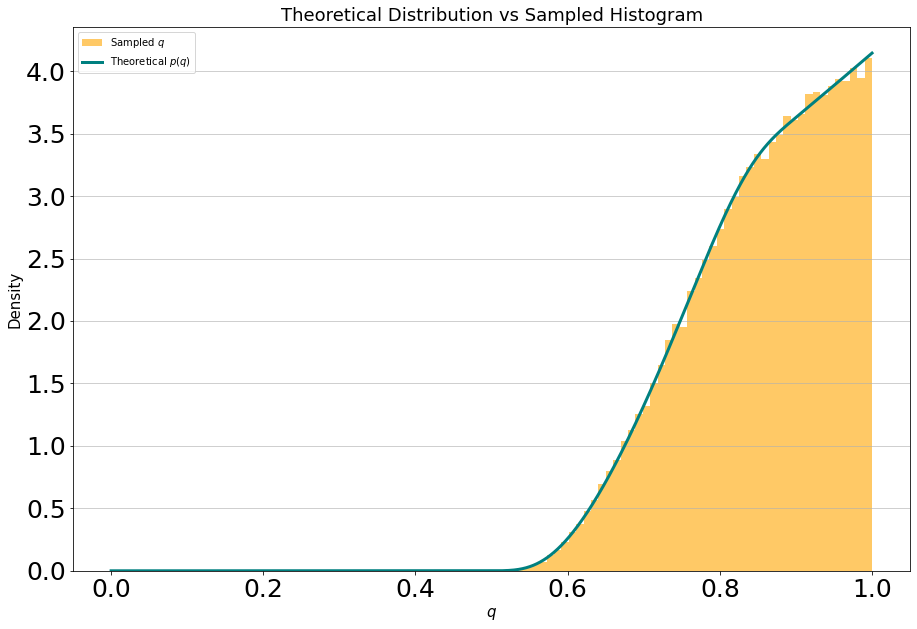

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
# Plot the histogram of the sampled probabilities
ax.hist(q_samples, bins=50, density=True, alpha=0.6, color='orange', label='Sampled $q$')

# Plot the theoretical distribution
ax.plot(q_values, p_q_values, label='Theoretical $p(q)$', color='teal',linewidth=3)

# Labels and title
ax.set_xlabel('$q$', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
plt.title('Theoretical Distribution vs Sampled Histogram', fontsize=18)

# Set log scale
#ax.set_yscale('log')

# Legends
ax.legend(loc='upper left')

# Show plot
plt.grid(axis='y', alpha=0.75)

In [14]:
#Masses
lamb=0.1
alpha=2.63
m_max=86
mu_m=33.07
sigma_m=5.7
x=np.linspace(m_min,m_max,10000)
def tonorm(x,alpha):
    return x**(-alpha)
integrand=tonorm(x,alpha)  
norm=np.trapz(integrand,x)
def PowerLawPlusPeak(m1, m_min, m_max, lamb, alpha, mu, sigma_m, dm):
    #m1 = np.clip(m1, m_min, m_max)  # Ensure m1 is within [m_min, m_max]
    #x=np.linspace(m_min,m_max,10000)
    #integrand=tonorm(x,alpha)  
    #norm=np.trapz(integrand,x)
    powlaw = (1 - lamb) * (m1 ** (-alpha))/1
    gauss = lamb * np.exp(-(m1 - mu) ** 2 / (2 * sigma_m ** 2)) / (np.sqrt(2 * np.pi) * sigma_m)
    tmp = S(m1, m_min, dm) * np.float64((powlaw + gauss))
    return tmp

In [26]:
# Define the function with parameters
PowerLawPlusPeak_with_params = partial(PowerLawPlusPeak, m_min=5,
                                       m_max=m_max,
                                       lamb=lamb,
                                       alpha=alpha,
                                       mu=mu_m,
                                       sigma_m=sigma_m,
                                       dm=dm)

# Number of samples
num_samples = 1_00_000

# Sample the probability distribution
m1_samples = return_samples(PowerLawPlusPeak_with_params, m_min, m_max, num_samples)

# Generate theoretical distribution for plotting
m1_values = np.linspace(m_min+0.001, m_max, 10000)
p_m1_values = PowerLawPlusPeak_with_params(m1_values)
p_m1_values=p_m1_values/np.trapz(p_m1_values,m1_values)

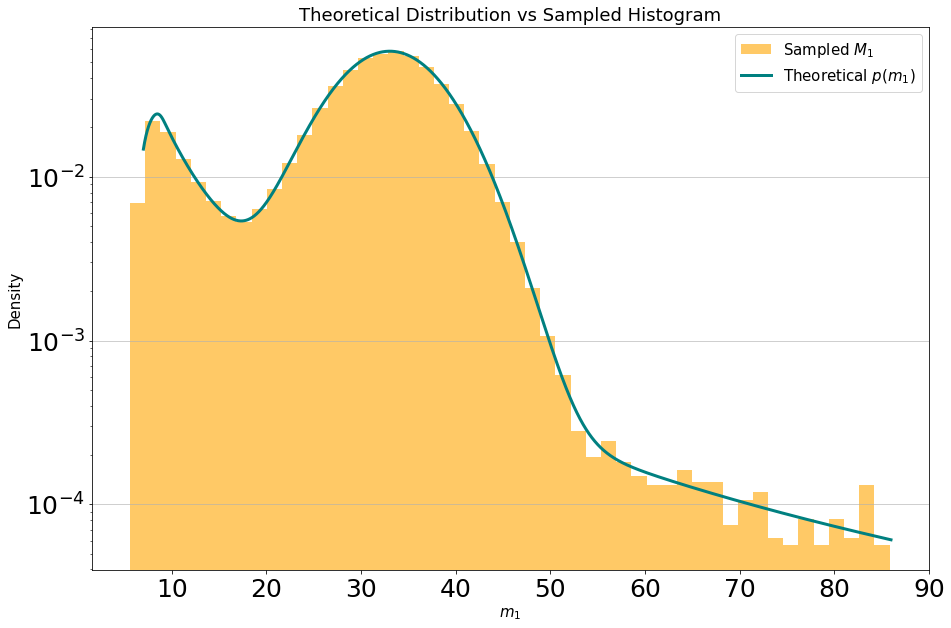

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
# Plot the histogram of the sampled probabilities
ax.hist(m1_samples, bins=50, density=True, alpha=0.6, color='orange', label='Sampled $M_1$')

# Plot the theoretical distribution
ax.plot(m1_values[m1_values>7], p_m1_values[m1_values>7], label='Theoretical $p(m_1)$', color='teal',linewidth=3)

# Labels and title
ax.set_xlabel('$m_1$', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
plt.title('Theoretical Distribution vs Sampled Histogram', fontsize=18)

# Set log scale
ax.set_yscale('log')

# Legends
ax.legend(loc='upper right',prop={'size': 15})

# Show plot
plt.grid(axis='y', alpha=0.75)